Use it to parse the JSONL logs and produce tables/plots:

Load all experiments/runs/compare/**/metrics.jsonl.

Aggregate by {task, kind, seq} the last ppl/acc, mean tokens/s, and peak MB.

Plot:

tokens/s vs seq (log-scale seq) — spectral should curve as ~n log n; vanilla flattens then collapses.

peak MB vs seq — vanilla quadratically worse.

quality bars (ppl lower is better, acc higher is better).

In [80]:
# Parse metrics and build comparison report (robust paths + fill missing keys)
import json, glob, re, math
from pathlib import Path
from IPython.display import display
import pandas as pd

# Candidate roots: current dir (notebooks/), repo root (..), and one level above
cwd = Path.cwd()
one_up = cwd.parent
root_candidates = [cwd, one_up, one_up.parent]
patterns = [
    'experiments/compare/**/metrics.jsonl',
    'experiments/runs/**/metrics.jsonl',
]
paths_set = set()
for base in root_candidates:
    for pat in patterns:
        for p in glob.glob(str(base / pat), recursive=True):
            paths_set.add(p)
paths = sorted(paths_set)

if not paths:
    print("No metrics.jsonl files found under experiments/compare or experiments/runs relative to:")
    for base in root_candidates:
        print(" -", base)
    df = pd.DataFrame()
    display(df)
else:
    print(f"Found {len(paths)} metrics files")
    rows = []
    for path in paths:
        try:
            with open(path, "r", encoding="utf-8") as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        rec = json.loads(line)
                        rec.setdefault("run_id", Path(path).parents[0].name)
                        rec.setdefault("_path", path)
                        rows.append(rec)
                    except json.JSONDecodeError:
                        # skip malformed lines
                        continue
        except OSError as e:
            print(f"Failed to read {path}: {e}")
    df = pd.DataFrame(rows)
    if df.empty:
        print("Parsed 0 records from metrics files.")
        display(df)
    else:
        # ---- Infer missing {task, kind, seq} from run_id and path ----
        def infer_from_run(run_id: str, path: str):
            task = None; kind = None; seq = None
            name = run_id or ""
            pnorm = (path or "").replace("\\","/")
            # 1) compare.py:  "{task}_{kind}_T{seq}_{stamp}"
            m = re.match(r"^(?P<task>\w+)_(?P<kind>spectral|vanilla)_T(?P<seq>\d+)_", name)
            if m:
                task = m.group("task"); kind = m.group("kind"); seq = int(m.group("seq"))
            else:
                # 2) train_lm.py: "{kind}_T{seq}_{stamp}" under experiments/runs/lm
                m2 = re.match(r"^(?P<kind>spectral|vanilla)_T(?P<seq>\d+)_", name)
                if m2:
                    kind = m2.group("kind"); seq = int(m2.group("seq"))
                # Fallbacks from path patterns
                if kind is None:
                    if re.search(r"/(spectral)/", pnorm): kind = "spectral"
                    elif re.search(r"/(vanilla)/", pnorm): kind = "vanilla"
                if seq is None:
                    mT = re.search(r"[_\-/]T(?P<seq>\d+)[_\-/]", pnorm)
                    if mT:
                        seq = int(mT.group("seq"))
                if task is None:
                    if "/runs/lm/" in pnorm or re.search(r"/(^|_)lm(_|/)", name):
                        task = "lm"
                    elif "/compare/imdb_" in pnorm or re.search(r"(^|_)imdb(_|/)", name):
                        task = "imdb"
            return task, kind, seq

        # Build per-run inference maps
        run_ids = sorted(set(df.get("run_id", pd.Series(dtype=str)).dropna().tolist()))
        task_map, kind_map, seq_map = {}, {}, {}
        for rid in run_ids:
            pth = df.loc[df["run_id"] == rid, "_path"].iloc[0]
            t,k,s = infer_from_run(rid, pth)
            if t is not None: task_map[rid] = t
            if k is not None: kind_map[rid] = k
            if s is not None: seq_map[rid] = s

        if "task" not in df.columns: df["task"] = pd.NA
        if "kind" not in df.columns: df["kind"] = pd.NA
        if "seq"  not in df.columns: df["seq"]  = pd.NA
        df["task"] = df["task"].fillna(df["run_id"].map(task_map))
        df["kind"] = df["kind"].fillna(df["run_id"].map(kind_map))
        df["seq"]  = df["seq"].fillna(df["run_id"].map(seq_map))

        # Coerce seq to numeric if possible
        df["seq"] = pd.to_numeric(df["seq"], errors="coerce")

        # ---- determine grouping keys ----
        group_keys = [c for c in ["task","kind","seq"] if c in df.columns]
        if not group_keys:
            # fall back to run_id grouping
            group_keys = ["run_id"] if "run_id" in df.columns else []
        if not group_keys:
            raise ValueError(f"No grouping keys found in metrics. Columns present: {list(df.columns)[:30]}")

        # Filter out rows missing any group key
        mask_ok = pd.Series([True]*len(df))
        for k in group_keys:
            mask_ok &= df[k].notna()
        df_g = df[mask_ok].copy()
        if df_g.empty:
            print("All records missing grouping keys after inference; cannot aggregate.")
            display(df.head())
        else:
            # last train record per group (if present)
            if "event" in df_g.columns:
                train_df = df_g[df_g["event"] == "train"]
            else:
                train_df = pd.DataFrame()
            if not train_df.empty:
                last_train = (train_df.sort_values("step") if "step" in train_df.columns else train_df
                              ).groupby(group_keys, as_index=False).tail(1)
            else:
                last_train = pd.DataFrame(columns=df_g.columns)

            # last val record per group (if present) for ppl/acc
            if "event" in df_g.columns:
                val_df = df_g[df_g["event"] == "val"]
            else:
                val_df = pd.DataFrame()
            if not val_df.empty:
                last_val = (val_df.sort_values("step") if "step" in val_df.columns else val_df
                            ).groupby(group_keys, as_index=False).tail(1)
            else:
                last_val = pd.DataFrame(columns=df_g.columns)

            # first throughput record per group (if present)
            if "event" in df_g.columns:
                thr_df = df_g[df_g["event"] == "throughput"]
            else:
                thr_df = pd.DataFrame()
            if not thr_df.empty:
                first_thr = thr_df.groupby(group_keys, as_index=False).head(1)
            else:
                first_thr = pd.DataFrame(columns=df_g.columns)

            # merge and sort: (((train ⨁ val) ⨁ thr))
            rep = None
            if not last_train.empty or not last_val.empty:
                rep = pd.merge(last_train, last_val, on=group_keys, suffixes=("_train","_val"), how="outer")
            elif not first_thr.empty:
                rep = first_thr.copy()

            if rep is None:
                rep = pd.DataFrame(columns=group_keys)

            if not first_thr.empty:
                rep = pd.merge(rep, first_thr, on=group_keys, suffixes=("","_thr"), how="outer")

            if not rep.empty:
                sort_cols = [k for k in ["seq","kind","task","run_id"] if k in rep.columns]
                rep = rep.sort_values(sort_cols)

                # Presence flags for diagnostics
                rep["has_train"] = rep.filter(regex=r"^event(_train)?$").notna().any(axis=1) if "event_train" in rep.columns or "event" in rep.columns else False
                rep["has_val"]   = rep.filter(regex=r"^event_val$").notna().any(axis=1) if "event_val" in rep.columns else False
                rep["has_thr"]   = rep.filter(regex=r"^event_thr$").notna().any(axis=1) if "event_thr" in rep.columns else False

                # Tidy projection: unify metric names to avoid NA where possible
                def coalesce(frame, cols):
                    out = None
                    for c in cols:
                        if c in frame.columns:
                            out = frame[c] if out is None else out.where(out.notna(), frame[c])
                    if out is None:
                        out = pd.Series([pd.NA]*len(frame), index=frame.index)
                    return out

                tidy = rep[group_keys].copy()
                # Performance metrics primarily from throughput
                tidy["tokens_per_s"] = coalesce(rep, ["tokens_per_s_thr","tokens_per_s"])  
                tidy["ms_per_it"]    = coalesce(rep, ["ms_per_it_thr","ms_per_it"])        
                tidy["peakMB"]       = coalesce(rep, ["peakMB_thr","peakMB"])              
                # Quality metrics from multiple possible names
                tidy["ppl"]          = coalesce(rep, ["ppl_val","val_ppl","ppl_train","ppl"])               
                tidy["acc"]          = coalesce(rep, ["acc_val","val_acc","acc_train","acc"])               
                tidy["loss"]         = coalesce(rep, ["loss_val","val_loss","loss_train","loss"])              
                tidy["has_train"]    = rep["has_train"]
                tidy["has_val"]      = rep["has_val"]
                tidy["has_thr"]      = rep["has_thr"]

                # Derive ppl from loss if missing (LM only)
                if "ppl" in tidy.columns and "loss" in tidy.columns:
                    m = tidy["ppl"].isna() & tidy["loss"].notna()
                    if m.any():
                        tidy.loc[m, "ppl"] = tidy.loc[m, "loss"].apply(lambda v: math.exp(v) if v < 20 else float("inf"))

                # Drop rows that lack all metrics
                metric_cols = ["tokens_per_s","peakMB","ppl","acc","loss"]
                all_missing = tidy[metric_cols].isna().all(axis=1)
                if all_missing.any():
                    print(f"Dropping {int(all_missing.sum())} groups with no available metrics.")
                    tidy = tidy[~all_missing]

                # Pretty display: cast numerics and fill missing as '-'
                tidy_display = tidy.copy()
                num_cols = [c for c in metric_cols if c in tidy_display.columns]
                for c in num_cols:
                    tidy_display[c] = pd.to_numeric(tidy_display[c], errors="coerce")
                for c in num_cols:
                    # round to 3 decimals for readability
                    tidy_display[c] = tidy_display[c].map(lambda x: round(x, 3) if pd.notna(x) else x)
                # fill remaining NaN with '-'
                tidy_display[num_cols] = tidy_display[num_cols].fillna('-')

                # Export CSVs: numeric and pretty
                try:
                    out_dir = Path.cwd().parent / 'experiments' / 'compare'
                    out_dir.mkdir(parents=True, exist_ok=True)
                    # numeric version (keep NaN for downstream analysis)
                    tidy.to_csv(out_dir / 'benchmark_report_numeric.csv', index=False)
                    # pretty version for quick sharing
                    tidy_display.to_csv(out_dir / 'benchmark_report_pretty.csv', index=False)
                    print(f"Saved CSVs to {out_dir}")
                except Exception as e:
                    print(f"Could not save CSVs: {e}")

                # Sort for readability and show
                sort_cols = [c for c in ["task","kind","seq"] if c in tidy_display.columns]
                tidy_display = tidy_display.sort_values(sort_cols)

                # Show diagnostics if any group lacks one side
                missing_train = int((~tidy["has_train"]).sum()) if "has_train" in tidy.columns else 0
                missing_val   = int((~tidy["has_val"]).sum())   if "has_val" in tidy.columns   else 0
                missing_thr   = int((~tidy["has_thr"]).sum())   if "has_thr" in tidy.columns   else 0
                if missing_train or missing_val or missing_thr:
                    print(f"Groups missing metrics — train: {missing_train}, val: {missing_val}, throughput: {missing_thr}")

                display(tidy_display.head(50))
            else:
                print("No 'train', 'val', or 'throughput' events found in metrics.")

Found 27 metrics files
Saved CSVs to c:\workspace\AI\spectral-attention\experiments\compare
Groups missing metrics — train: 0, val: 16, throughput: 25
Saved CSVs to c:\workspace\AI\spectral-attention\experiments\compare
Groups missing metrics — train: 0, val: 16, throughput: 25


,task,kind,seq,tokens_per_s,ms_per_it,peakMB,ppl,acc,loss,has_train,has_val,has_thr
0,attention_bench,spectral,16.0,17793.594,0.899200,0.000,-,-,-,True,False,False
1,attention_bench,spectral,32.0,66095.218,0.968300,0.000,-,-,-,True,False,False
2,attention_bench,spectral,512.0,202424.348,10.117360,102.458,-,-,-,True,False,False
3,attention_bench,spectral,1024.0,225203.901,18.187962,168.667,-,-,-,True,False,False
4,attention_bench,spectral,2048.0,169721.846,48.267210,305.085,-,-,-,True,False,False
5,attention_bench,spectral,4096.0,166547.252,98.374484,577.921,-,-,-,True,False,False
6,attention_bench,spectral,8192.0,157982.141,207.415850,1123.593,-,-,-,True,False,False
7,attention_bench,spectral,16384.0,131140.253,499.739772,2214.937,-,-,-,True,False,False
8,attention_bench,vanilla,32.0,109514.032,0.584400,0.000,-,-,-,True,False,False
9,attention_bench,vanilla,512.0,132411.967,15.466880,130.281,-,-,-,True,False,False


## Plots

The cells below visualize performance and quality:

- tokens/s vs seq (log-scale) per kind and task
- peak MB vs seq (log-scale)
- quality bars for ppl (lower is better) and acc (higher is better)


In [81]:
# Load tidy CSV and prepare dataframe for plotting
import pandas as pd
from pathlib import Path

csv_path = Path.cwd().parent / 'experiments' / 'compare' / 'benchmark_report_numeric.csv'
try:
    df_report = pd.read_csv(csv_path)
except FileNotFoundError:
    # fallback: reconstruct from the current session if available
    try:
        df_report  # noqa: F821
    except NameError:
        raise FileNotFoundError(f"Could not find {csv_path}. Please run the aggregation cell above first.")

# Cast numeric columns and filter valid rows
for col in [c for c in ['seq','tokens_per_s','peakMB','ppl','acc','loss'] if c in df_report.columns]:
    df_report[col] = pd.to_numeric(df_report[col], errors='coerce')

# Keep rows that have seq and at least one perf metric
mask = df_report['seq'].notna() & (df_report[['tokens_per_s','peakMB']].notna().any(axis=1))
df_plot = df_report[mask].copy()

# Normalize kind/task strings for consistent legend
for c in [c for c in ['kind','task'] if c in df_plot.columns]:
    df_plot[c] = df_plot[c].astype(str)

print(f"Plotting {len(df_plot)} rows from {csv_path}")

Plotting 25 rows from c:\workspace\AI\spectral-attention\experiments\compare\benchmark_report_numeric.csv


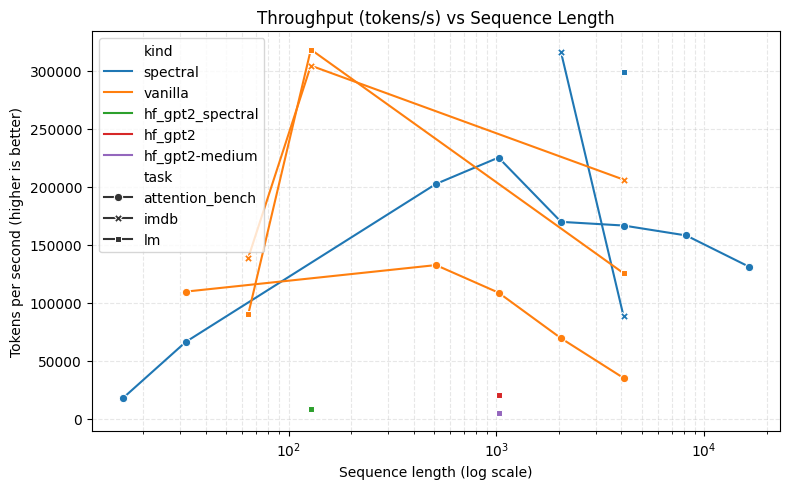

In [82]:
# Plot tokens/s vs seq (log-scale on seq)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
ax = sns.lineplot(
    data=df_plot.dropna(subset=['seq','tokens_per_s']),
    x='seq', y='tokens_per_s', hue='kind', style='task', markers=True, dashes=False
)
ax.set_xscale('log')
ax.set_title('Throughput (tokens/s) vs Sequence Length')
ax.set_xlabel('Sequence length (log scale)')
ax.set_ylabel('Tokens per second (higher is better)')
ax.grid(True, which='both', ls='--', alpha=0.3)
plt.tight_layout()
plt.show()

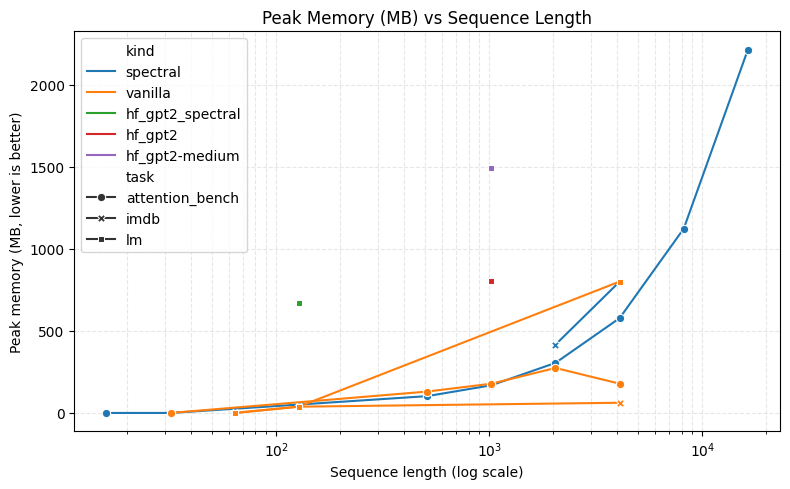

In [83]:
# Plot peakMB vs seq (log-scale on seq)
plt.figure(figsize=(8,5))
ax = sns.lineplot(
    data=df_plot.dropna(subset=['seq','peakMB']),
    x='seq', y='peakMB', hue='kind', style='task', markers=True, dashes=False
)
ax.set_xscale('log')
ax.set_title('Peak Memory (MB) vs Sequence Length')
ax.set_xlabel('Sequence length (log scale)')
ax.set_ylabel('Peak memory (MB, lower is better)')
ax.grid(True, which='both', ls='--', alpha=0.3)
plt.tight_layout()
plt.show()

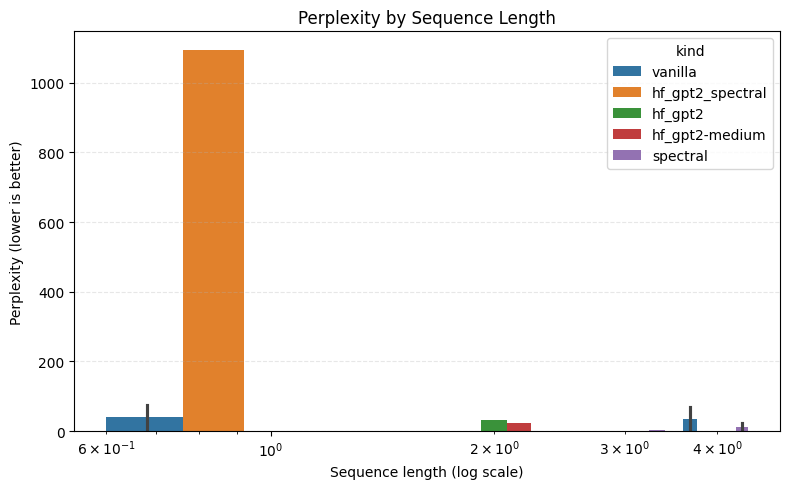

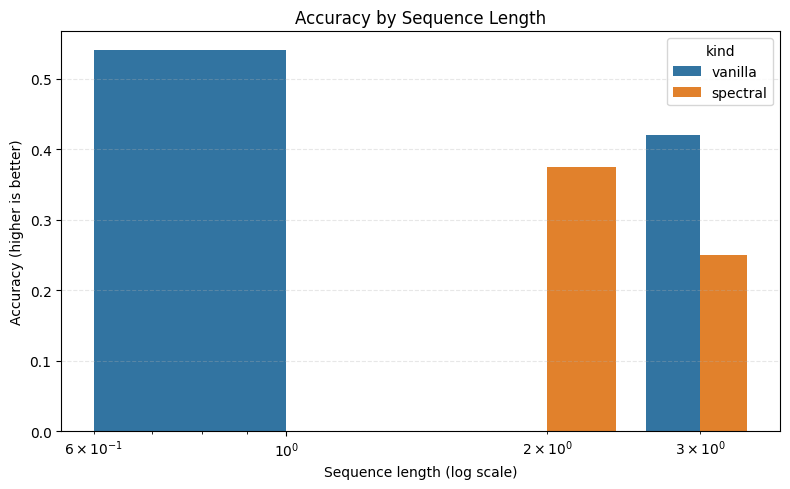

In [84]:
# Quality bars: ppl (lower better) and acc (higher better)
import numpy as np

# Prepare per-group best available quality (val preferred, else train)
q_cols = [c for c in ['ppl','acc'] if c in df_report.columns]
df_q = df_report.dropna(subset=['seq'])
# pick a single row per (task, kind, seq)
keys = [c for c in ['task','kind','seq'] if c in df_q.columns]
df_q = (df_q
        .sort_values(keys + ['ppl','acc'], na_position='last')
        .drop_duplicates(subset=keys, keep='first')
       )

# PPL bar chart (lower is better)
if 'ppl' in df_q.columns:
    plt.figure(figsize=(8,5))
    ax = sns.barplot(
        data=df_q.dropna(subset=['ppl']),
        x='seq', y='ppl', hue='kind'
    )
    ax.set_xscale('log')
    ax.set_title('Perplexity by Sequence Length')
    ax.set_xlabel('Sequence length (log scale)')
    ax.set_ylabel('Perplexity (lower is better)')
    ax.grid(True, axis='y', ls='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# ACC bar chart (higher is better)
if 'acc' in df_q.columns:
    plt.figure(figsize=(8,5))
    ax = sns.barplot(
        data=df_q.dropna(subset=['acc']),
        x='seq', y='acc', hue='kind'
    )
    ax.set_xscale('log')
    ax.set_title('Accuracy by Sequence Length')
    ax.set_xlabel('Sequence length (log scale)')
    ax.set_ylabel('Accuracy (higher is better)')
    ax.grid(True, axis='y', ls='--', alpha=0.3)
    plt.tight_layout()
    plt.show()